In [376]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50,50]

In [429]:
class Brain:
    
    def __init__(self, num_neurons, synnaptic_density, initial_active_neuron_density, neuronal_max_threshold):
        self.num_neurons = num_neurons
        self.synnaptic_density = synnaptic_density
        self.initial_active_neuron_density = initial_active_neuron_density
        self.neuronal_max_threshold = neuronal_max_threshold

        # neuronal states
        self.neuronal_states = 1*(np.random.rand(num_neurons,1) < initial_active_neuron_density)
        self.neuronal_thresholds = np.ones([num_neurons,1])*neuronal_max_threshold
        
        # synaptic strengths
        self.synapses = 1*(np.random.rand(num_neurons,num_neurons) < synnaptic_density)
        self.synapses_a = 0.1*self.synapses.copy()
        self.synapses_b = self.synapses_a.copy()
    
    def get_synaptic_activationa(self):
        """activation of the synnapses is True if the random number exceeds the synaptic_threshold"""
        synaptic_threshold = self.synapses_a/(self.synapses_a+self.synapses_b)
        synaptic_activations = (self.synapses.copy()*np.random.rand(self.num_neurons, self.num_neurons)) > (synaptic_threshold)
        return synaptic_activations
        
    def update_neuronal_states(self):
        """the next neuronal state depends upon what neurons are active currently, what synapses are active, and 
        whether the resulting activation is above the threshold for activation."""
        synaptic_activations = self.get_synaptic_activationa()
        next_neuronal_states = synaptic_activations @ self.neuronal_states
        next_neuronal_states = 1*(next_neuronal_states>self.neuronal_thresholds)
        self.neuronal_states = next_neuronal_states
        
        # decrease the neuronal_threshold for all neurons but reset neuronal_thresholds for neurons that activated
        self.neuronal_thresholds = self.neuronal_thresholds - 1
        self.neuronal_thresholds[self.neuronal_states == 1] = self.neuronal_max_threshold

    def simulate_brain(self, num_updates=150):
        neuron_history = self.neuronal_states

        for i in range(num_updates):
            self.update_neuronal_states()
            neuron_history = np.concatenate([neuron_history,self.neuronal_states], axis=1)

        plt.imshow(neuron_history)

<ipython-input-429-0c4e104fd3f4>:20: RuntimeWarning: invalid value encountered in true_divide
  synaptic_threshold = self.synapses_a/(self.synapses_a+self.synapses_b)


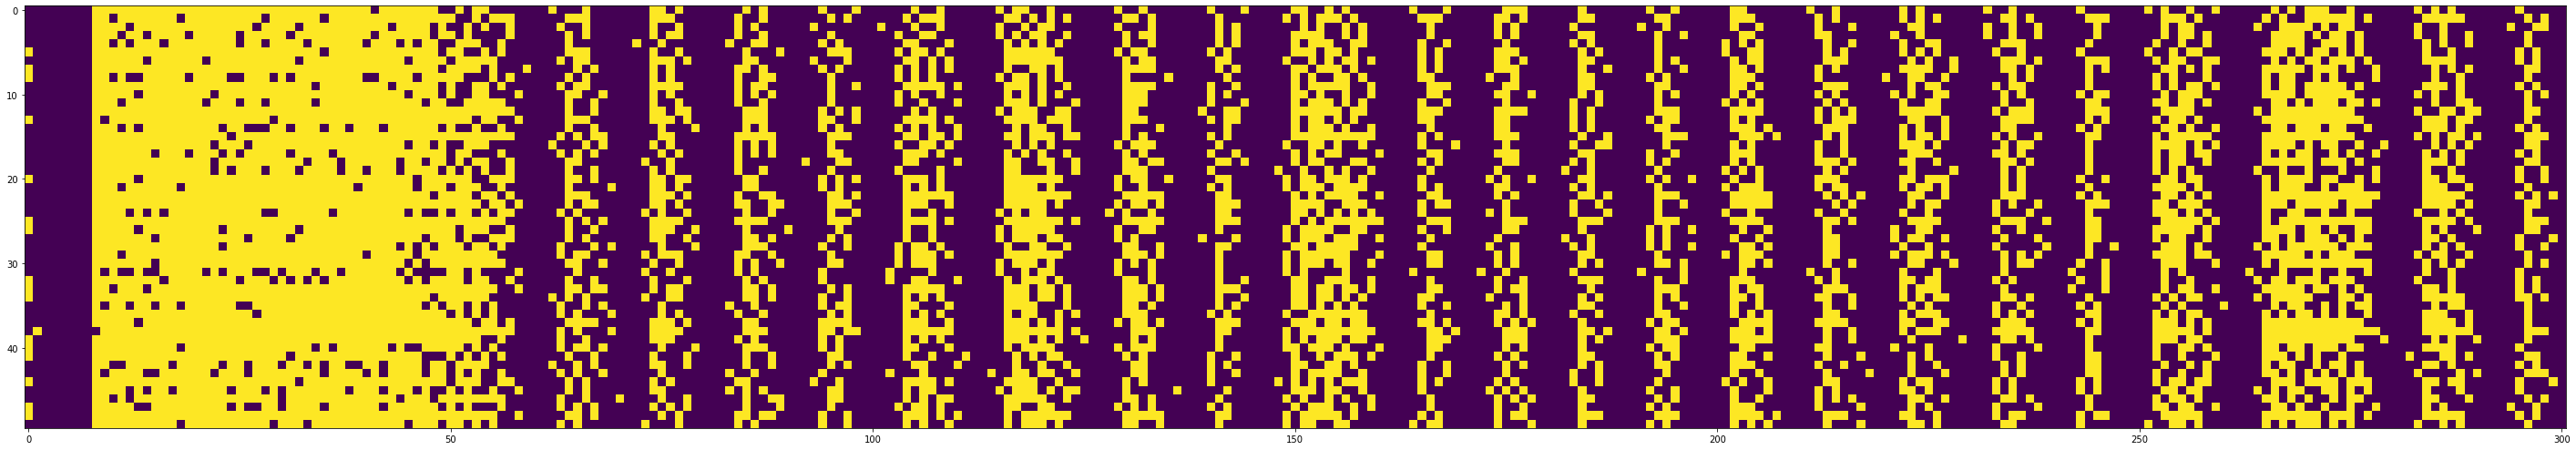

In [464]:
brain = Brain(
    num_neurons=50, 
    synnaptic_density=0.40,
    initial_active_neuron_density=.3,
    neuronal_max_threshold=6,
)
brain.simulate_brain(300)

In [ ]:
class Brain:
    
    def __init__(self, num_neurons, synnaptic_density, initial_active_neuron_density, neuronal_max_threshold):
        self.num_neurons = num_neurons
        self.synnaptic_density = synnaptic_density
        self.initial_active_neuron_density = initial_active_neuron_density
        self.neuronal_max_threshold = neuronal_max_threshold

        # neuronal states
        self.neuronal_states = 1*(np.random.rand(num_neurons,1) < initial_active_neuron_density)
        self.neuronal_thresholds = np.ones([num_neurons,1])*neuronal_max_threshold
        
        # synaptic strengths
        self.synapses = 1*(np.random.rand(num_neurons,num_neurons) < synnaptic_density)
        self.synapses_a = 0.1*self.synapses.copy()
        self.synapses_b = self.synapses_a.copy()
    
    def get_synaptic_activationa(self):
        """activation of the synnapses is True if the random number exceeds the synaptic_threshold"""
        synaptic_threshold = self.synapses_a/(self.synapses_a+self.synapses_b)
        synaptic_activations = (self.synapses.copy()*np.random.rand(self.num_neurons, self.num_neurons)) > (synaptic_threshold)
        return synaptic_activations
        
    def update_neuronal_states(self):
        """the next neuronal state depends upon what neurons are active currently, what synapses are active, and 
        whether the resulting activation is above the threshold for activation."""
        synaptic_activations = self.get_synaptic_activationa()
        next_neuronal_states = synaptic_activations @ self.neuronal_states
        next_neuronal_states = 1*(next_neuronal_states>self.neuronal_thresholds)
        self.neuronal_states = next_neuronal_states
        
        # decrease the neuronal_threshold for all neurons but reset neuronal_thresholds for neurons that activated
        self.neuronal_thresholds = self.neuronal_thresholds - 1
        self.neuronal_thresholds[self.neuronal_states == 1] = self.neuronal_max_threshold

    def simulate_brain(self, num_updates=150):
        neuron_history = self.neuronal_states

        for i in range(num_updates):
            self.update_neuronal_states()
            neuron_history = np.concatenate([neuron_history,self.neuronal_states], axis=1)

        plt.imshow(neuron_history)

In [474]:
self = Brain(
    num_neurons=50, 
    synnaptic_density=0.40,
    initial_active_neuron_density=.3,
    neuronal_max_threshold=4,
)
# self.simulate_brain(300)

neuronal_states = self.neuronal_states

In [475]:
self.update_neuronal_states()
next_neuronal_states = self.neuronal_states

<ipython-input-429-0c4e104fd3f4>:20: RuntimeWarning: invalid value encountered in true_divide
  synaptic_threshold = self.synapses_a/(self.synapses_a+self.synapses_b)


In [476]:
next_neuronal_states

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

# next

* get a better plot
* make the activation threshold of the neurons drain as time goes on unless they activate, then they get the max threshold

# ideas
1. represent inhibitory synapses with negative S_a